# SSP Tactile Encoding
This demo illuistrates the memorization and replay of spatial tactile perception.

In [1]:
%matplotlib inline
from functools import partial

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import nengo
import nengo_spa as spa
import numpy as np
import seaborn as sns
from IPython.display import HTML, display
from nengo_extras.plot_spikes import plot_spikes, preprocess_spikes
from skimage.draw import disk, rectangle

from ssp.dynamics import Trajectory
from ssp.interface import Object
from ssp.maps import Spatial2D
from ssp.plots import create_gif, heatmap_animation

2023-10-25 00:49:49.128731: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-25 00:49:49.128865: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-25 00:49:49.129248: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-25 00:49:49.200321: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-25 00:49:50.258442: W tensorflow/compiler/

In [2]:
class StimulusGenerator2D:
    """Generates a 2D field with stimuli of a given profile."""

    def __init__(self, dim=(256,), sample_dim=(20,), profile=("ring", 150, 10)):
        try:
            if len(dim) < 2:
                dim = (dim[0], dim[0])
        except:
            dim = (dim, dim)
        try:
            if len(sample_dim) < 2:
                sample_dim = (sample_dim[0], sample_dim[0])
        except:
            sample_dim = (sample_dim, sample_dim)
        self.dim = np.asarray(dim)
        self.sample_dim = np.asarray(sample_dim)
        self.__field = np.zeros((dim[0], dim[1], 3))

        match profile:
            case tuple():
                match profile[0]:
                    case "ring":
                        r0, c0 = disk((dim[1] // 2, dim[0] // 2), np.min(dim) // 3)
                        self.__field[r0, c0] = (1, 1, 1)
                        r1, c1 = disk(
                            (dim[1] // 2, dim[0] // 2), np.min(dim) // 3 - profile[1]
                        )
                        self.__field[r1, c1] = (0, 0, 0)
                    case "square":
                        start = self.dim[:2] // 2 - profile[1] // 2
                        end = start + profile[1]
                        r0, c0 = rectangle(start, end)
                        self.__field[r0, c0] = (1, 1, 1)
                        r1, c1 = rectangle(start + profile[2], end - profile[2])
                        self.__field[r1, c1] = (0, 0, 0)
            case _:
                pass

        self.annotation = {"thickness": 2}

    @property
    def field(self):
        return self.__field

    def sample(self, locations):
        """Samples the stimulus field at the given locations.

        Args:
            locations (array like): Array of locations to sample from.

        Returns:
            tuple: Tuple of sampled stimulus and annotated field.
        """
        locations = np.asarray(locations)
        end = locations + self.sample_dim

        sampled = []
        annotated = []
        thickness = self.annotation["thickness"]
        if not isinstance(locations, (list, np.ndarray)):
            locations = [locations]
        for i, loc in enumerate(locations):
            # Plots annotation rectangle
            ann = np.copy(self.field)
            r0, c0 = rectangle(loc, end=end[i], shape=self.field.shape)
            ann[r0, c0] = (1, 0, 0)
            r1, c1 = rectangle(
                loc + thickness,
                end=end[i] - thickness,
                shape=self.field.shape,
            )
            ann[r1, c1] = self.field[r1, c1]
            sample = np.copy(self.field[loc[0] : end[i][0], loc[1] : end[i][1]])
            sampled.append(sample)
            annotated.append(ann)
        return sampled, annotated


def create_animation(
    figures,
    titles=None,
    interval=100,
    cmap=sns.diverging_palette(220, 20, sep=20, as_cmap=True),
):
    """Auxiliary function to create an animation of lists of figures.

    Args:
        samples (array like): Samples of the stimulus.
        annotations (array like): Annotated field of the stimulus.
        interval (int, optional): Delay between frames in milliseconds.. Defaults to 100.
        cmap (palette, optional): Seaborn palette. Defaults sns.diverging_palette(220, 20, sep=20, as_cmap=True).

    Returns:
        _type_: _description_
    """
    if not isinstance(figures, list | np.ndarray):
        figures = np.asarray([figures])

    fig, axes = plt.subplots(1, len(figures), figsize=(12, 6))
    if len(figures) == 1:
        axes = [axes]
    n_steps = len(figures[0])
    images = []
    for step in range(n_steps):
        frame = []
        for i, figure in enumerate(figures):
            frame.append(axes[i].imshow(figure[step], cmap=cmap, animated=True))

        images.append(frame)
    if titles is not None:
        for i in range(len(axes)):
            axes[i].set_title(titles[i])
    ani = animation.ArtistAnimation(fig, images, interval=interval, blit=True)
    plt.close()
    return ani

In [3]:
field_dim = 200
sample_dim = 15
n_samples = 50

SG2D = StimulusGenerator2D(
    dim=field_dim, sample_dim=sample_dim, profile=("square", 120, 10)
)
t = np.linspace(0, 2 * np.pi, n_samples)
r = 60
xs, ys = 100 + r * np.cos(t), 100 + r * np.sin(t)
locations = list(zip(xs.astype(int), ys.astype(int)))
sampled, annotated = SG2D.sample(locations)

ani = create_animation([sampled, annotated], titles=["ROI", "Field"])
ani.save("simulation.mp4", writer=animation.FFMpegWriter(fps=10))
display(HTML(ani.to_jshtml()))

In [4]:
# Adaoted from ssp_grid_cell_utils.py and ssp_grid_cell_examples.ipynb
# Accurate representation for spatial cognition using grid cells
# Nicole Sandra-Yaffa Dumont & Chris Eliasmith


def ssp_plane_basis(K):
    # Create the bases vectors X,Y as described in the paper with the wavevectors
    # (k_i = (u_i,v_i)) given in a matrix K. To get hexganal patterns use 3 K vectors 120 degs apart
    # To get mulit-scales/orientation, give many such sets of 3 K vectors
    # K is _ by 2
    d = K.shape[0]
    FX = np.ones((d * 2 + 1,), dtype="complex")
    FX[0:d] = np.exp(1.0j * K[:, 0])
    FX[-d:] = np.flip(np.conj(FX[0:d]))
    FX = np.fft.ifftshift(FX)
    FY = np.ones((d * 2 + 1,), dtype="complex")
    FY[0:d] = np.exp(1.0j * K[:, 1])
    FY[-d:] = np.flip(np.conj(FY[0:d]))
    FY = np.fft.ifftshift(FY)

    X = spa.SemanticPointer(data=np.fft.ifft(FX))
    Y = spa.SemanticPointer(data=np.fft.ifft(FY))
    return X, Y


def generate_grid_cell_basis(n_scales, n_rotates, scale_min=0.5, scale_max=1.8):
    """Generates basis vectors with ``d = n_scales * n_rotates * 6 + 1``."""
    K_hex = np.array([[0, 1], [np.sqrt(3) / 2, -0.5], [-np.sqrt(3) / 2, -0.5]])

    # Combining multiple n_scales sets of 3 wave vectors that give hexagonal grid interference patterns
    # each set of 3 giving a different grid resolution
    scales = np.linspace(scale_min, scale_max, n_scales)
    K_scales = np.vstack([K_hex * i for i in scales])

    # Combining multiple n_rotates sets of 3 wave vectors that give hexagonal grid interference patterns
    # each set of 3 giving a different grid orientation
    thetas = np.arange(0, n_rotates) * np.pi / (3 * n_rotates)
    R_mats = np.stack(
        [
            np.stack([np.cos(thetas), -np.sin(thetas)], axis=1),
            np.stack([np.sin(thetas), np.cos(thetas)], axis=1),
        ],
        axis=1,
    )
    # TODO: don't double transpose
    K_rotates = (R_mats @ K_hex.T).transpose(1, 2, 0).T.reshape(-1, 2)

    # Multiple resolutions and orientations
    # TODO: don't double transpose
    K_scale_rotates = (R_mats @ K_scales.T).transpose(1, 2, 0).T.reshape(-1, 2)

    # Generate the (X, Y) basis vectors
    X, Y = ssp_plane_basis(K_scale_rotates)
    d = n_scales * n_rotates * 6 + 1
    assert len(X) == len(Y) == d
    return X, Y, d

In [5]:
# points in the simulation are within [0, 1]^2 and then visualized
# on [-0.5, 0.5]^2 with a scale of sqrt(2)*grid_size such
# that the diameter of each ball is roughly the same scale
grid_size = 10
ssp_radius = np.sqrt(2)  # open problem: deriving this
ssp_scale = ssp_radius * grid_size

X, Y, d = generate_grid_cell_basis(
    n_scales=10, n_rotates=12, scale_min=0.9, scale_max=3.5
)
dim = d
print("Dimensionality:", d)

ssp_map = Spatial2D(
    dim=dim, scale=ssp_scale, X=X, Y=Y, rng=np.random.RandomState(seed=0)
)

ssp_map.build_grid(x_len=1, y_len=1, x_spaces=101, y_spaces=101)

/home/fraaw/miniconda3/envs/ml/lib/python3.11/site-packages/nengo_spa/semantic_pointer.py:64: ComplexWarning: Casting complex values to real discards the imaginary part
  self.v = np.array(data, dtype=float)


Dimensionality: 721


In [6]:
ssp_map.update_from_objs([])
mems = []
objs = []
for i, loc in enumerate(locations):
    loc = np.asarray(loc)
    obj = Object(f"Obj_{i}", color=[1, 0, 0], shape=[1])
    obj.location = loc / field_dim
    if sampled[i].sum() > 1:
        ssp_map.add_object(obj)

    mems.append(ssp_map.heatmap_scores)

ani = create_animation([mems], titles=["Memory"])
display(HTML(ani.to_jshtml()))

In [7]:
def drawpath(ax, coord):
    ax.plot(coord[:, 0], coord[:, 1], linestyle="--", color="black", alpha=0.4)
    ax.scatter(coord[:-1, 0], coord[:-1, 1], color="black")
    ax.arrow(
        coord[-2, 0],
        coord[-2, 1],
        coord[-1, 0] - coord[-2, 0],
        coord[-1, 1] - coord[-2, 1],
        width=0,
        length_includes_head=False,
        head_width=0.03,
        color="black",
        ls="--",
    )

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

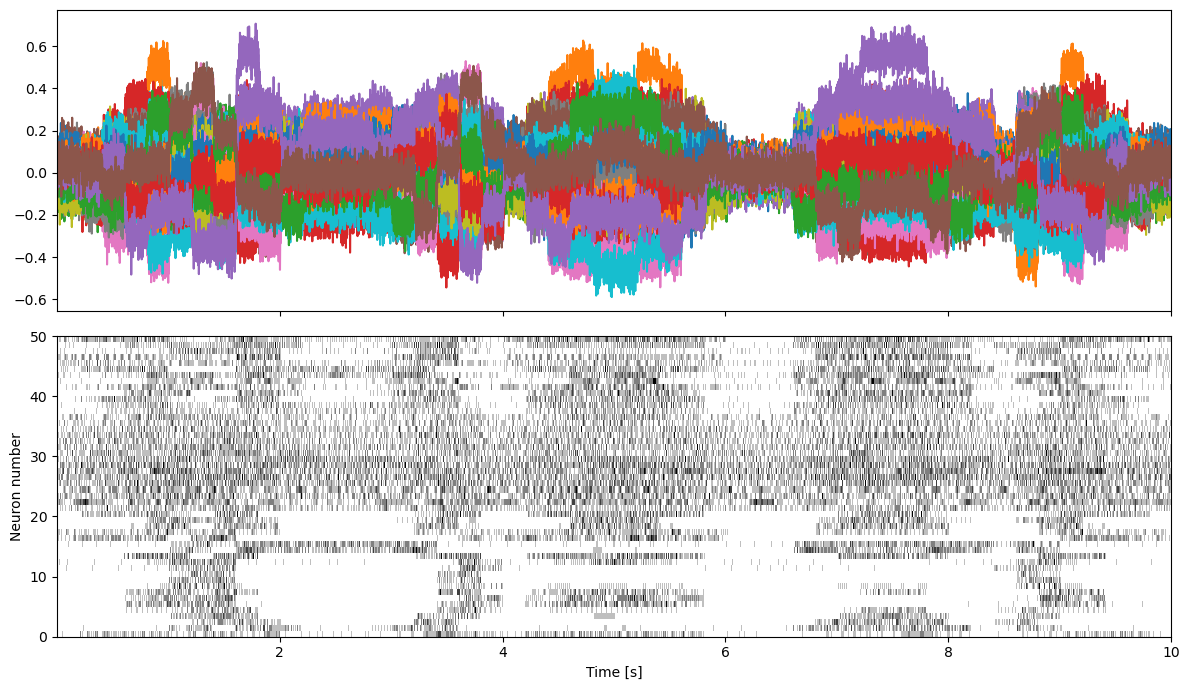

In [8]:
stimuli = np.sum(sampled, axis=3)
stimuli = (stimuli - stimuli.min()) / (stimuli.max() - stimuli.min())
input_dim = stimuli.shape[1] * stimuli.shape[2]
n_samples = stimuli.shape[0]
duration = 0.2  # in seconds
time = n_samples * duration  # in seconds

with nengo.Network() as model:
    inp = nengo.Node(
        output=lambda t: stimuli[int(t / duration) % stimuli.shape[0]].flatten()
    )
    ens = nengo.Ensemble(n_neurons=stimuli[0].size, dimensions=36)
    nengo.Connection(inp, ens.neurons)
    p = nengo.Probe(ens, synapse=0.01)
    p_spikes = nengo.Probe(ens.neurons)

with nengo.Simulator(model, dt=1e-3) as sim:
    sim.run(time)

dig, axs = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
axs[0].plot(sim.trange(), sim.data[p])
plot_spikes(*preprocess_spikes(sim.trange(), sim.data[p_spikes]), ax=axs[1])
axs[1].set_ylabel("Neuron number")
plt.xlabel("Time [s]")
plt.tight_layout()
plt.show()